[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/Sistemas-Multimedia/Sistemas-Multimedia.github.io/blob/master/milestones/07-DCT/block_DCT_compression.ipynb)

# IIII... video compression

The frames are transformed with YCoCg+DCT, the subbands are ordered to provide local correlation, quantized and compressed with PNG. RDO is performed over all the frames of the GOP (Group Of Pictures). A comparison is done when no RDO among frames has been used. Notice that RDO causes a higher encoding latency (concretely, $G$ times the latency of the pure IIII... scheme, where $G$ is the number of frames per GOP).

## Parameters

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
!ln -sf ~/MRVC/src/image_3.py .
import image_3 as image
!ln -sf ~/MRVC/src/image_1.py .
import image_1 as component
!ln -sf ~/MRVC/src/block_DCT.py .
!ln -sf ~/MRVC/src/YCoCg.py .
import YCoCg as color
#!ln -sf ~/MRVC/src/color_DCT.py .
#import color_DCT as color
#!ln -sf ~/MRVC/src/RGB.py .
#import RGB as color
import cv2
!ln -sf ~/quantization/information.py .
import information
!ln -sf ~/quantization/distortion.py .
import distortion
import os
import pylab
!ln -sf ~/quantization/deadzone_quantizer.py .
import deadzone_quantizer as Q
import math
import block_DCT as DCT

In [2]:
G = 3 # GOP size
HOME = os.environ["HOME"]
!~/MRVC/sequences/container/runme.sh
test_image = "/tmp/original_"

/home/vruiz/MRVC/sequences/container/container_cif.y4m exists.
ffmpeg version n4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11.1.0 (GCC)
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libdrm --enable-libfreetype --enable-libfribidi --enable-libgsm --enable-libiec61883 --enable-libjack --enable-libmfx --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopus --enable-libpulse --enable-librav1e --enable-librsvg --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtheora --enable-libv4l2 --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enabl

In [3]:
block_y_side = block_x_side = 8

In [4]:
N_components = 3

In [5]:
entropy_estimator = "PNG"
if entropy_estimator == "PNG":
    def compute_BPP(_image, filename_prefix):
        BPP = image.write(_image, filename_prefix, 0)*8/_image.size
        return BPP
else:
    def compute_BPP(_image, filename_prefix=''):
        entropy = information.entropy(_image.flatten().astype(np.int16))
        return entropy

## Quantization steps

In [6]:
Q_steps = [128, 64, 32, 16, 8]

## Using same $\Delta$ for all coefficients

In [7]:
for i in range(G):
    x = image.read(test_image, i)
    xx = color.from_RGB(x.astype(np.int16) - 128)

    RD_points_no_RDO = []
    for Q_step in Q_steps:
        yy = DCT.analyze_image(xx, block_y_side, block_x_side)
        yy_k = DCT.uniform_quantize(yy, block_y_side, block_x_side, N_components, Q_step)
        yy_dQ = DCT.uniform_dequantize(yy_k, block_y_side, block_x_side, N_components, Q_step)
        zz_dQ = DCT.synthesize_image(yy_dQ, block_y_side, block_x_side)
        z_dQ = color.to_RGB(zz_dQ) + 128
        MSE = distortion.MSE(x, z_dQ)
        yy_k_subbands = DCT.get_subbands(yy_k, block_y_side, block_x_side)
        BPP = compute_BPP((yy_k_subbands + 128).astype(np.uint8), f"/tmp/{Q_step}_")
        RD_points_no_RDO.append((BPP, MSE))
        print(i, Q_step, end=' ', flush=True)

image_3.read: /tmp/original_000.png (288, 352, 3) uint8 175184 
image_3.write: /tmp/128_000.png (288, 352, 3) uint8 4105 
0 128 image_3.write: /tmp/64_000.png (288, 352, 3) uint8 7666 
0 64 image_3.write: /tmp/32_000.png (288, 352, 3) uint8 13505 
0 32 image_3.write: /tmp/16_000.png (288, 352, 3) uint8 23321 
0 16 image_3.write: /tmp/8_000.png (288, 352, 3) uint8 39347 
0 8 image_3.read: /tmp/original_001.png (288, 352, 3) uint8 175373 
image_3.write: /tmp/128_000.png (288, 352, 3) uint8 4104 
1 128 image_3.write: /tmp/64_000.png (288, 352, 3) uint8 7645 
1 64 image_3.write: /tmp/32_000.png (288, 352, 3) uint8 13500 
1 32 image_3.write: /tmp/16_000.png (288, 352, 3) uint8 23329 
1 16 image_3.write: /tmp/8_000.png (288, 352, 3) uint8 39332 
1 8 image_3.read: /tmp/original_002.png (288, 352, 3) uint8 175621 
image_3.write: /tmp/128_000.png (288, 352, 3) uint8 4071 
2 128 image_3.write: /tmp/64_000.png (288, 352, 3) uint8 7638 
2 64 image_3.write: /tmp/32_000.png (288, 352, 3) uint8 13513

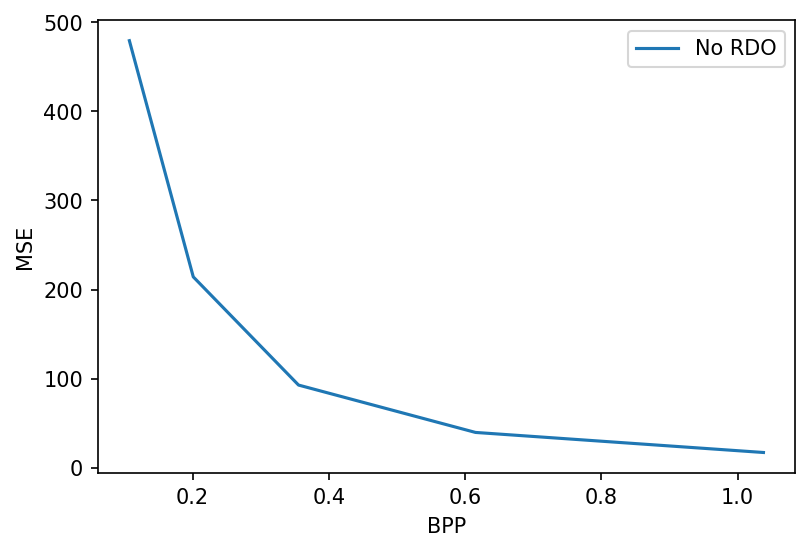

In [8]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_no_RDO), label="No RDO")
pylab.title("")
pylab.xlabel("BPP")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

## Using RDO (Rate/Distortion Optimization)

### Find the optimal progression of quantization steps

In [9]:
RD_points = []
RD_slopes = []
N_components = xx.shape[2]
single_list = []

for i in range(G):
    x = image.read(test_image, i)
    blocks_in_y = x.shape[0]//block_y_side
    blocks_in_x = x.shape[1]//block_x_side

    #xx = color.from_RGB(x.astype(np.int16) - 128)
    xx = color.from_RGB(x.astype(np.int16))
    xx[...,0] -= np.average(xx[...,0]).astype(np.int16)
    xx[...,1] -= np.average(xx[...,1]).astype(np.int16)
    xx[...,2] -= np.average(xx[...,2]).astype(np.int16)

    yy = DCT.analyze_image(xx, block_y_side, block_x_side)
    yy = DCT.get_subbands(yy, block_y_side, block_x_side)

    for _y in range(block_y_side):
        for _x in range(block_x_side):
            for _c in range(N_components):
                sbc = yy[blocks_in_y*_y : blocks_in_y*(_y + 1),
                         blocks_in_x*_x : blocks_in_x*(_x + 1),
                         _c]
                sbc_energy = information.average_energy(sbc)
                # The first point of each RD curve has a maximum distortion equal
                # to the energy of the subband and a rate = 0
                RD_points.append([(0, sbc_energy)])
                RD_slopes.append([])

    for _y in range(block_y_side):
        for _x in range(block_x_side):
            for _c in range(N_components):
                sbc = yy[blocks_in_y*_y : blocks_in_y*(_y + 1),
                         blocks_in_x*_x : blocks_in_x*(_x + 1),
                        _c]
                counter = 0
                for Q_step in Q_steps:
                    sbc_k = Q.quantize(sbc, Q_step)
                    sbc_dQ = Q.dequantize(sbc_k, Q_step)
                    MSE = distortion.MSE(sbc, sbc_dQ)
                    BPP = component.write(sbc_k.astype(np.uint8), f"/tmp/{_y}_{_x}_{Q_step}_", 0)*8/xx.size
                    #BPP_Q_indexes = information.PNG_BPP((Q_indexes.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
                    #BPP_Q_indexes = information.entropy(Q_indexes.astype(np.int16).flatten())
                    point = (BPP, MSE)
                    RD_points[(_y * block_x_side * N_components + _x * N_components ) + _c].append(point)
                    print("Q_step =", Q_step, "BPP =", point[0], "MSE =", point[1])
                    delta_BPP = BPP - RD_points[(_y * block_x_side * N_components + _x * N_components ) + _c][counter][0]
                    delta_MSE = RD_points[(_y * block_x_side * N_components + _x * N_components ) + _c][counter][1] - MSE
                    if delta_BPP > 0:
                        slope = delta_MSE/delta_BPP
                        RD_slopes[(_y * block_x_side * N_components + _x * N_components) + _c].append((slope, (_y, _x, _c), Q_step))
                    else:
                        slope = 0
                    #RD_slopes[(_y * block_x_side * N_components + _x * N_components) + _c].append((Q_step, slope, (_y, _x, _c)))
                    counter += 1

    def filter_slopes(slopes):
        filtered_slopes = []
        slopes_iterator = iter(slopes)
        prev = next(slopes_iterator)
        for curr in slopes_iterator:
            if prev[0] < curr[0]:
                print(f"deleted {prev}")
            else:
                filtered_slopes.append(prev)
            prev = curr
        filtered_slopes.append(prev)
        return filtered_slopes

    filtered_slopes = []
    for i in RD_slopes:
        filtered_slopes.append(filter_slopes(i))

    for l in filtered_slopes:
        #l = filter_slopes(l)
        for i in l:
            #if i[1] > 0:
            single_list.append(i)

image_3.read: /tmp/original_000.png (288, 352, 3) uint8 175184 
image_1.write: /tmp/0_0_128_000.png (36, 44) uint8 460 
Q_step = 128 BPP = 0.01210016835016835 MSE = 5619.523871527777
image_1.write: /tmp/0_0_64_000.png (36, 44) uint8 606 
Q_step = 64 BPP = 0.015940656565656564 MSE = 1355.2208412247476
image_1.write: /tmp/0_0_32_000.png (36, 44) uint8 765 
Q_step = 32 BPP = 0.02012310606060606 MSE = 343.3420533459596
image_1.write: /tmp/0_0_16_000.png (36, 44) uint8 939 
Q_step = 16 BPP = 0.024700126262626264 MSE = 84.03397253787878
image_1.write: /tmp/0_0_8_000.png (36, 44) uint8 1136 
Q_step = 8 BPP = 0.02988215488215488 MSE = 20.77639678030303
image_1.write: /tmp/0_0_128_000.png (36, 44) uint8 225 
Q_step = 128 BPP = 0.005918560606060606 MSE = 2831.338462752525
image_1.write: /tmp/0_0_64_000.png (36, 44) uint8 313 
Q_step = 64 BPP = 0.00823337542087542 MSE = 1443.3788667929293
image_1.write: /tmp/0_0_32_000.png (36, 44) uint8 483 
Q_step = 32 BPP = 0.012705176767676768 MSE = 318.71725

image_1.write: /tmp/1_3_8_000.png (36, 44) uint8 578 
Q_step = 8 BPP = 0.01520412457912458 MSE = 11.98170346784613
image_1.write: /tmp/1_3_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 11.207880818308906
image_1.write: /tmp/1_3_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 11.207880818308906
image_1.write: /tmp/1_3_32_000.png (36, 44) uint8 125 
Q_step = 32 BPP = 0.003288089225589226 MSE = 10.456958509281128
image_1.write: /tmp/1_3_16_000.png (36, 44) uint8 155 
Q_step = 16 BPP = 0.004077230639730639 MSE = 7.231713428468115
image_1.write: /tmp/1_3_8_000.png (36, 44) uint8 208 
Q_step = 8 BPP = 0.005471380471380472 MSE = 4.302808230399784
image_1.write: /tmp/1_3_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 2.669861999603244
image_1.write: /tmp/1_3_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 2.669861999603244
image_1.write: /tmp/1_3_32_000.png (36, 44) uint8 

image_1.write: /tmp/3_1_64_000.png (36, 44) uint8 259 
Q_step = 64 BPP = 0.006812920875420876 MSE = 309.47508163543324
image_1.write: /tmp/3_1_32_000.png (36, 44) uint8 380 
Q_step = 32 BPP = 0.009995791245791245 MSE = 122.69498251803854
image_1.write: /tmp/3_1_16_000.png (36, 44) uint8 536 
Q_step = 16 BPP = 0.0140993265993266 MSE = 48.36592850439135
image_1.write: /tmp/3_1_8_000.png (36, 44) uint8 783 
Q_step = 8 BPP = 0.020596590909090908 MSE = 15.51668226737827
image_1.write: /tmp/3_1_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 15.08341477674852
image_1.write: /tmp/3_1_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 15.08341477674852
image_1.write: /tmp/3_1_32_000.png (36, 44) uint8 132 
Q_step = 32 BPP = 0.003472222222222222 MSE = 12.724972566560705
image_1.write: /tmp/3_1_16_000.png (36, 44) uint8 156 
Q_step = 16 BPP = 0.004103535353535354 MSE = 9.104324519624052
image_1.write: /tmp/3_1_8_000.png (36, 44) uint8 237 

image_1.write: /tmp/4_7_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 5.892382426507185
image_1.write: /tmp/4_7_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 5.892382426507185
image_1.write: /tmp/4_7_32_000.png (36, 44) uint8 127 
Q_step = 32 BPP = 0.003340698653198653 MSE = 5.0638038243232355
image_1.write: /tmp/4_7_16_000.png (36, 44) uint8 129 
Q_step = 16 BPP = 0.003393308080808081 MSE = 5.0638038243232355
image_1.write: /tmp/4_7_8_000.png (36, 44) uint8 180 
Q_step = 8 BPP = 0.004734848484848485 MSE = 3.4934474649377547
image_1.write: /tmp/4_7_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 0.42384243550183726
image_1.write: /tmp/4_7_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 0.42384243550183726
image_1.write: /tmp/4_7_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 0.42384243550183726
image_1.write: /tmp/4_7_16_000.png (36, 

Q_step = 8 BPP = 0.0032091750841750843 MSE = 0.4036079872185182
image_1.write: /tmp/5_7_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 0.09146329606244652
image_1.write: /tmp/5_7_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 0.09146329606244652
image_1.write: /tmp/5_7_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 0.09146329606244652
image_1.write: /tmp/5_7_16_000.png (36, 44) uint8 122 
Q_step = 16 BPP = 0.0032091750841750843 MSE = 0.09146329606244652
image_1.write: /tmp/5_7_8_000.png (36, 44) uint8 122 
Q_step = 8 BPP = 0.0032091750841750843 MSE = 0.09146329606244652
image_1.write: /tmp/6_0_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 358.10012927039475
image_1.write: /tmp/6_0_64_000.png (36, 44) uint8 166 
Q_step = 64 BPP = 0.004366582491582492 MSE = 202.93477393481237
image_1.write: /tmp/6_0_32_000.png (36, 44) uint8 245 
Q_step = 32 BPP = 0.006444654882154

image_1.write: /tmp/7_4_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 0.6885475166571304
image_1.write: /tmp/7_4_16_000.png (36, 44) uint8 122 
Q_step = 16 BPP = 0.0032091750841750843 MSE = 0.6885475166571304
image_1.write: /tmp/7_4_8_000.png (36, 44) uint8 129 
Q_step = 8 BPP = 0.003393308080808081 MSE = 0.5983551168133558
image_1.write: /tmp/7_4_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 0.10973740268228088
image_1.write: /tmp/7_4_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 0.10973740268228088
image_1.write: /tmp/7_4_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 0.10973740268228088
image_1.write: /tmp/7_4_16_000.png (36, 44) uint8 122 
Q_step = 16 BPP = 0.0032091750841750843 MSE = 0.10973740268228088
image_1.write: /tmp/7_4_8_000.png (36, 44) uint8 122 
Q_step = 8 BPP = 0.0032091750841750843 MSE = 0.10973740268228088
image_1.write: /tmp/7_5_128_000.png (3

image_3.read: /tmp/original_001.png (288, 352, 3) uint8 175373 
image_1.write: /tmp/0_0_128_000.png (36, 44) uint8 458 
Q_step = 128 BPP = 0.012047558922558923 MSE = 5524.945292771465
image_1.write: /tmp/0_0_64_000.png (36, 44) uint8 605 
Q_step = 64 BPP = 0.015914351851851853 MSE = 1331.9553937815656
image_1.write: /tmp/0_0_32_000.png (36, 44) uint8 767 
Q_step = 32 BPP = 0.02017571548821549 MSE = 338.278626104798
image_1.write: /tmp/0_0_16_000.png (36, 44) uint8 940 
Q_step = 16 BPP = 0.024726430976430975 MSE = 84.07913115530303
image_1.write: /tmp/0_0_8_000.png (36, 44) uint8 1140 
Q_step = 8 BPP = 0.029987373737373736 MSE = 20.942767518939394
image_1.write: /tmp/0_0_128_000.png (36, 44) uint8 224 
Q_step = 128 BPP = 0.005892255892255892 MSE = 2829.3576191603534
image_1.write: /tmp/0_0_64_000.png (36, 44) uint8 311 
Q_step = 64 BPP = 0.008180765993265993 MSE = 1464.832366635101
image_1.write: /tmp/0_0_32_000.png (36, 44) uint8 485 
Q_step = 32 BPP = 0.012757786195286195 MSE = 330.31

image_1.write: /tmp/0_7_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 9.29340692688077
image_1.write: /tmp/0_7_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 9.29340692688077
image_1.write: /tmp/0_7_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 9.29340692688077
image_1.write: /tmp/0_7_16_000.png (36, 44) uint8 143 
Q_step = 16 BPP = 0.003761574074074074 MSE = 7.4201074341507365
image_1.write: /tmp/0_7_8_000.png (36, 44) uint8 208 
Q_step = 8 BPP = 0.005471380471380472 MSE = 4.225920790030087
image_1.write: /tmp/0_7_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 1.7187452440188054
image_1.write: /tmp/0_7_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 1.7187452440188054
image_1.write: /tmp/0_7_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 1.7187452440188054
image_1.write: /tmp/0_7_16_000.png (36, 44) uin

image_1.write: /tmp/1_3_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 2.6969588276309273
image_1.write: /tmp/1_3_16_000.png (36, 44) uint8 122 
Q_step = 16 BPP = 0.0032091750841750843 MSE = 2.6969588276309273
image_1.write: /tmp/1_3_8_000.png (36, 44) uint8 145 
Q_step = 8 BPP = 0.0038141835016835017 MSE = 2.0284872119070383
image_1.write: /tmp/1_4_128_000.png (36, 44) uint8 134 
Q_step = 128 BPP = 0.00352483164983165 MSE = 283.5984436766881
image_1.write: /tmp/1_4_64_000.png (36, 44) uint8 189 
Q_step = 64 BPP = 0.004971590909090909 MSE = 156.3244229518617
image_1.write: /tmp/1_4_32_000.png (36, 44) uint8 259 
Q_step = 32 BPP = 0.006812920875420876 MSE = 71.46471919431555
image_1.write: /tmp/1_4_16_000.png (36, 44) uint8 370 
Q_step = 16 BPP = 0.009732744107744109 MSE = 26.799157518290162
image_1.write: /tmp/1_4_8_000.png (36, 44) uint8 518 
Q_step = 8 BPP = 0.013625841750841751 MSE = 10.87191509474132
image_1.write: /tmp/1_4_128_000.png (36, 44) uint8 1

image_1.write: /tmp/2_5_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 0.6993633186385093
image_1.write: /tmp/2_5_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 0.6993633186385093
image_1.write: /tmp/2_5_16_000.png (36, 44) uint8 122 
Q_step = 16 BPP = 0.0032091750841750843 MSE = 0.6993633186385093
image_1.write: /tmp/2_5_8_000.png (36, 44) uint8 122 
Q_step = 8 BPP = 0.0032091750841750843 MSE = 0.6993633186385093
image_1.write: /tmp/2_6_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 48.36006555316381
image_1.write: /tmp/2_6_64_000.png (36, 44) uint8 125 
Q_step = 64 BPP = 0.003288089225589226 MSE = 44.16019267891349
image_1.write: /tmp/2_6_32_000.png (36, 44) uint8 142 
Q_step = 32 BPP = 0.00373526936026936 MSE = 34.337360937426354
image_1.write: /tmp/2_6_16_000.png (36, 44) uint8 219 
Q_step = 16 BPP = 0.005760732323232323 MSE = 18.544563964400194
image_1.write: /tmp/2_6_8_000.png (36, 44) uin

image_1.write: /tmp/3_7_16_000.png (36, 44) uint8 122 
Q_step = 16 BPP = 0.0032091750841750843 MSE = 0.19559364488153105
image_1.write: /tmp/3_7_8_000.png (36, 44) uint8 122 
Q_step = 8 BPP = 0.0032091750841750843 MSE = 0.19559364488153105
image_1.write: /tmp/4_0_128_000.png (36, 44) uint8 198 
Q_step = 128 BPP = 0.005208333333333333 MSE = 1133.925722064394
image_1.write: /tmp/4_0_64_000.png (36, 44) uint8 276 
Q_step = 64 BPP = 0.00726010101010101 MSE = 424.12774226641415
image_1.write: /tmp/4_0_32_000.png (36, 44) uint8 391 
Q_step = 32 BPP = 0.010285143097643097 MSE = 158.65299479166666
image_1.write: /tmp/4_0_16_000.png (36, 44) uint8 583 
Q_step = 16 BPP = 0.015335648148148149 MSE = 51.200974589646464
image_1.write: /tmp/4_0_8_000.png (36, 44) uint8 811 
Q_step = 8 BPP = 0.021333122895622895 MSE = 16.79440893308081
image_1.write: /tmp/4_0_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 11.083392518939394
image_1.write: /tmp/4_0_64_000.png (36, 44) ui

image_1.write: /tmp/5_2_16_000.png (36, 44) uint8 122 
Q_step = 16 BPP = 0.0032091750841750843 MSE = 1.0275414559823464
image_1.write: /tmp/5_2_8_000.png (36, 44) uint8 132 
Q_step = 8 BPP = 0.003472222222222222 MSE = 0.8617704339948936
image_1.write: /tmp/5_3_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 113.57073795435737
image_1.write: /tmp/5_3_64_000.png (36, 44) uint8 134 
Q_step = 64 BPP = 0.00352483164983165 MSE = 96.26195616675477
image_1.write: /tmp/5_3_32_000.png (36, 44) uint8 191 
Q_step = 32 BPP = 0.005024200336700336 MSE = 55.04522695446589
image_1.write: /tmp/5_3_16_000.png (36, 44) uint8 282 
Q_step = 16 BPP = 0.007417929292929293 MSE = 27.96163503089669
image_1.write: /tmp/5_3_8_000.png (36, 44) uint8 432 
Q_step = 8 BPP = 0.011363636363636364 MSE = 12.070352881861174
image_1.write: /tmp/5_3_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 2.870884066639372
image_1.write: /tmp/5_3_64_000.png (36, 44) uint8 

Q_step = 64 BPP = 0.0032091750841750843 MSE = 4.1786708983665015
image_1.write: /tmp/7_1_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 4.1786708983665015
image_1.write: /tmp/7_1_16_000.png (36, 44) uint8 127 
Q_step = 16 BPP = 0.003340698653198653 MSE = 3.977801309225581
image_1.write: /tmp/7_1_8_000.png (36, 44) uint8 171 
Q_step = 8 BPP = 0.004498106060606061 MSE = 2.5271115792075043
image_1.write: /tmp/7_1_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 0.7144345052804923
image_1.write: /tmp/7_1_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 0.7144345052804923
image_1.write: /tmp/7_1_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 0.7144345052804923
image_1.write: /tmp/7_1_16_000.png (36, 44) uint8 122 
Q_step = 16 BPP = 0.0032091750841750843 MSE = 0.7144345052804923
image_1.write: /tmp/7_1_8_000.png (36, 44) uint8 122 
Q_step = 8 BPP = 0.0032091750841750843 MSE =

image_1.write: /tmp/7_5_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 0.14135776587011384
image_1.write: /tmp/7_5_16_000.png (36, 44) uint8 122 
Q_step = 16 BPP = 0.0032091750841750843 MSE = 0.14135776587011384
image_1.write: /tmp/7_5_8_000.png (36, 44) uint8 122 
Q_step = 8 BPP = 0.0032091750841750843 MSE = 0.14135776587011384
image_1.write: /tmp/7_6_128_000.png (36, 44) uint8 122 
Q_step = 128 BPP = 0.0032091750841750843 MSE = 1.5355618568843077
image_1.write: /tmp/7_6_64_000.png (36, 44) uint8 122 
Q_step = 64 BPP = 0.0032091750841750843 MSE = 1.5355618568843077
image_1.write: /tmp/7_6_32_000.png (36, 44) uint8 122 
Q_step = 32 BPP = 0.0032091750841750843 MSE = 1.5355618568843077
image_1.write: /tmp/7_6_16_000.png (36, 44) uint8 122 
Q_step = 16 BPP = 0.0032091750841750843 MSE = 1.5355618568843077
image_1.write: /tmp/7_6_8_000.png (36, 44) uint8 133 
Q_step = 8 BPP = 0.003498526936026936 MSE = 1.3799644687420203
image_1.write: /tmp/7_6_128_000.png (36,

StopIteration: 

In [10]:
sorted_slopes = sorted(single_list, key=lambda x: x[0])[::-1]

## Build the optimal RD curve

In [11]:
optimal_RD_points = []
yy_prog = np.zeros_like(yy)
Q_steps_combination = np.full(shape=(block_x_side, block_y_side, N_components), fill_value=99999999)
for s in sorted_slopes:
    sbc_index = s[1]
    _y = sbc_index[0]
    _x = sbc_index[1]
    _c = sbc_index[2]
    Q_steps_combination[_y, _x, _c] = s[2]
    yy_prog[blocks_in_y*_y : blocks_in_y*(_y + 1),
            blocks_in_x*_x : blocks_in_x*(_x + 1),
            _c] = yy[blocks_in_y*_y : blocks_in_y*(_y + 1),
                     blocks_in_x*_x : blocks_in_x*(_x + 1),
                     _c]
    yy_prog_k = DCT.quantize(yy_prog, Q_steps_combination)
    yy_prog_dQ = DCT.dequantize(yy_prog_k, Q_steps_combination)
    
    MSE = distortion.MSE(yy, yy_prog_dQ)

    BPP = image.write((yy_prog_k + 128).astype(np.uint8), f"/tmp/{_y}_{_x}_{_c}_{s[0]}_", 0)*8/xx.size
    point = (BPP, MSE)
    print("sbc =", sbc_index, "Q_step =", s[2], "BPP =", BPP, "MSE =", MSE)
    optimal_RD_points.append(point)

image_3.write: /tmp/0_0_0_11037814.539130434_000.png (288, 352, 3) uint8 2023 
sbc = (0, 0, 0) Q_step = 128 BPP = 0.05321443602693603 MSE = 365.47141722948487
image_3.write: /tmp/1_0_0_1183855.2922207448_000.png (288, 352, 3) uint8 2348 
sbc = (1, 0, 0) Q_step = 128 BPP = 0.06176346801346801 MSE = 319.6796978377937
image_3.write: /tmp/0_1_0_1175883.9544314384_000.png (288, 352, 3) uint8 2714 
sbc = (0, 1, 0) Q_step = 128 BPP = 0.07139099326599327 MSE = 271.6430765899146
image_3.write: /tmp/0_0_1_1122304.0000000002_000.png (288, 352, 3) uint8 2782 
sbc = (0, 0, 1) Q_step = 128 BPP = 0.0731797138047138 MSE = 237.01039561348364
image_3.write: /tmp/0_0_0_1110354.4109589045_000.png (288, 352, 3) uint8 3073 
sbc = (0, 0, 0) Q_step = 64 BPP = 0.08083438552188552 MSE = 215.17190655624458
image_3.write: /tmp/2_0_0_640304.5246369295_000.png (288, 352, 3) uint8 3274 
sbc = (2, 0, 0) Q_step = 128 BPP = 0.086121632996633 MSE = 194.0386486742837
image_3.write: /tmp/0_0_1_599598.5454545454_000.png (2

image_3.write: /tmp/4_3_0_62076.35156250002_000.png (288, 352, 3) uint8 9981 
sbc = (4, 3, 0) Q_step = 64 BPP = 0.2625473484848485 MSE = 45.45490676776759
image_3.write: /tmp/0_2_0_60940.62184214367_000.png (288, 352, 3) uint8 10149 
sbc = (0, 2, 0) Q_step = 32 BPP = 0.2669665404040404 MSE = 44.43202477904312
image_3.write: /tmp/1_2_0_58951.83290816324_000.png (288, 352, 3) uint8 10313 
sbc = (1, 2, 0) Q_step = 32 BPP = 0.27128051346801346 MSE = 43.59564802853377
image_3.write: /tmp/3_1_0_58682.91114088328_000.png (288, 352, 3) uint8 10514 
sbc = (3, 1, 0) Q_step = 32 BPP = 0.2765677609427609 MSE = 42.64233895815212
image_3.write: /tmp/0_6_0_58005.10859375_000.png (288, 352, 3) uint8 10549 
sbc = (0, 6, 0) Q_step = 64 BPP = 0.27748842592592593 MSE = 42.366324543451526
image_3.write: /tmp/1_5_0_57329.196093750026_000.png (288, 352, 3) uint8 10594 
sbc = (1, 5, 0) Q_step = 64 BPP = 0.27867213804713803 MSE = 42.00996143318216
image_3.write: /tmp/6_2_0_57304.31250000005_000.png (288, 352, 

image_3.write: /tmp/6_3_0_21993.754687499997_000.png (288, 352, 3) uint8 14437 
sbc = (6, 3, 0) Q_step = 64 BPP = 0.3797611531986532 MSE = 26.360699041825256
image_3.write: /tmp/4_0_0_21390.73015873015_000.png (288, 352, 3) uint8 14662 
sbc = (4, 0, 0) Q_step = 16 BPP = 0.38567971380471383 MSE = 25.80105310327307
image_3.write: /tmp/0_1_0_20767.293646723247_000.png (288, 352, 3) uint8 14831 
sbc = (0, 1, 0) Q_step = 16 BPP = 0.3901252104377104 MSE = 25.406186711005798
image_3.write: /tmp/0_2_1_20541.366923564176_000.png (288, 352, 3) uint8 14850 
sbc = (0, 2, 1) Q_step = 32 BPP = 0.390625 MSE = 25.307566446387312
image_3.write: /tmp/0_3_0_20497.066994691497_000.png (288, 352, 3) uint8 15045 
sbc = (0, 3, 0) Q_step = 16 BPP = 0.39575441919191917 MSE = 24.9677780893719
image_3.write: /tmp/1_6_0_20414.371728515616_000.png (288, 352, 3) uint8 15082 
sbc = (1, 6, 0) Q_step = 32 BPP = 0.3967276936026936 MSE = 24.8755738983053
image_3.write: /tmp/1_0_2_20408.07879317434_000.png (288, 352, 3) 

image_3.write: /tmp/6_1_0_12530.561617337737_000.png (288, 352, 3) uint8 21461 
sbc = (6, 1, 0) Q_step = 16 BPP = 0.5645254629629629 MSE = 14.58651284426984
image_3.write: /tmp/0_0_0_12207.106598984774_000.png (288, 352, 3) uint8 21672 
sbc = (0, 0, 0) Q_step = 8 BPP = 0.5700757575757576 MSE = 14.257677616997116
image_3.write: /tmp/7_0_1_12205.007467830912_000.png (288, 352, 3) uint8 21680 
sbc = (7, 0, 1) Q_step = 32 BPP = 0.5702861952861953 MSE = 14.229281121332154
image_3.write: /tmp/0_7_0_12179.292246093752_000.png (288, 352, 3) uint8 21803 
sbc = (0, 7, 0) Q_step = 16 BPP = 0.5735216750841751 MSE = 14.098564631509777
image_3.write: /tmp/0_1_2_11885.880037006578_000.png (288, 352, 3) uint8 21807 
sbc = (0, 1, 2) Q_step = 32 BPP = 0.5736268939393939 MSE = 14.059328641454297
image_3.write: /tmp/3_5_0_11752.416892178086_000.png (288, 352, 3) uint8 21957 
sbc = (3, 5, 0) Q_step = 16 BPP = 0.577572601010101 MSE = 13.924387724612615
image_3.write: /tmp/5_3_0_11610.987654976227_000.png (2

image_3.write: /tmp/0_3_1_5190.791593852794_000.png (288, 352, 3) uint8 26481 
sbc = (0, 3, 1) Q_step = 16 BPP = 0.6965751262626263 MSE = 10.4285159890703
image_3.write: /tmp/0_2_2_5182.458855124079_000.png (288, 352, 3) uint8 26491 
sbc = (0, 2, 2) Q_step = 16 BPP = 0.6968381734006734 MSE = 10.404567664219789
image_3.write: /tmp/1_1_2_5160.3850013469855_000.png (288, 352, 3) uint8 26501 
sbc = (1, 1, 2) Q_step = 16 BPP = 0.6971012205387206 MSE = 10.383603532005553
image_3.write: /tmp/6_4_0_5065.464158078458_000.png (288, 352, 3) uint8 26571 
sbc = (6, 4, 0) Q_step = 16 BPP = 0.6989425505050505 MSE = 10.34297736094487
image_3.write: /tmp/3_2_0_5063.092662617908_000.png (288, 352, 3) uint8 26921 
sbc = (3, 2, 0) Q_step = 8 BPP = 0.7081492003367004 MSE = 10.196164021488306
image_3.write: /tmp/2_1_0_5058.268345424105_000.png (288, 352, 3) uint8 27334 
sbc = (2, 1, 0) Q_step = 8 BPP = 0.7190130471380471 MSE = 10.020327268425778
image_3.write: /tmp/3_1_0_5055.858076705625_000.png (288, 352,

image_3.write: /tmp/5_2_1_3657.458077566963_000.png (288, 352, 3) uint8 36127 
sbc = (5, 2, 1) Q_step = 16 BPP = 0.9503103956228957 MSE = 6.252833039170877
image_3.write: /tmp/6_0_2_3654.57878154033_000.png (288, 352, 3) uint8 36142 
sbc = (6, 0, 2) Q_step = 8 BPP = 0.9507049663299664 MSE = 6.233599486977476
image_3.write: /tmp/0_4_1_3609.600000000006_000.png (288, 352, 3) uint8 36142 
sbc = (0, 4, 1) Q_step = 16 BPP = 0.9507049663299664 MSE = 6.22748364101788
image_3.write: /tmp/0_7_0_3553.6599084102754_000.png (288, 352, 3) uint8 36275 
sbc = (0, 7, 0) Q_step = 8 BPP = 0.9542034932659933 MSE = 6.185903515228029
image_3.write: /tmp/2_6_0_3533.315405868904_000.png (288, 352, 3) uint8 36463 
sbc = (2, 6, 0) Q_step = 8 BPP = 0.9591487794612794 MSE = 6.129411842134978
image_3.write: /tmp/1_6_1_3501.4509765625003_000.png (288, 352, 3) uint8 36468 
sbc = (1, 6, 1) Q_step = 16 BPP = 0.959280303030303 MSE = 6.122912328903836
image_3.write: /tmp/2_1_1_3497.7716385690787_000.png (288, 352, 3) u

image_3.write: /tmp/4_1_1_1919.3397810652461_000.png (288, 352, 3) uint8 38700 
sbc = (4, 1, 1) Q_step = 8 BPP = 1.0179924242424243 MSE = 5.268978904544215
image_3.write: /tmp/3_7_0_1898.2064094543462_000.png (288, 352, 3) uint8 38808 
sbc = (3, 7, 0) Q_step = 8 BPP = 1.0208333333333333 MSE = 5.248476032857855
image_3.write: /tmp/6_1_1_1858.684041341146_000.png (288, 352, 3) uint8 38830 
sbc = (6, 1, 1) Q_step = 8 BPP = 1.021412037037037 MSE = 5.234536499688433
image_3.write: /tmp/0_7_1_1809.296854654947_000.png (288, 352, 3) uint8 38880 
sbc = (0, 7, 1) Q_step = 8 BPP = 1.0227272727272727 MSE = 5.217900110916971
image_3.write: /tmp/1_2_2_1797.8620971679682_000.png (288, 352, 3) uint8 38901 
sbc = (1, 2, 2) Q_step = 8 BPP = 1.0232796717171717 MSE = 5.2075652701889945
image_3.write: /tmp/2_3_1_1789.8443069458012_000.png (288, 352, 3) uint8 38921 
sbc = (2, 3, 1) Q_step = 8 BPP = 1.023805765993266 MSE = 5.1973649962786395
image_3.write: /tmp/0_5_1_1753.2659258161266_000.png (288, 352, 3)

image_3.write: /tmp/0_5_2_721.4601745605471_000.png (288, 352, 3) uint8 39491 
sbc = (0, 5, 2) Q_step = 8 BPP = 1.0387994528619529 MSE = 5.0015160012428925
image_3.write: /tmp/5_4_1_705.9216064453142_000.png (288, 352, 3) uint8 39494 
sbc = (5, 4, 1) Q_step = 8 BPP = 1.038878367003367 MSE = 5.000314629489637
image_3.write: /tmp/6_7_0_694.1000802176344_000.png (288, 352, 3) uint8 39509 
sbc = (6, 7, 0) Q_step = 8 BPP = 1.0392729377104377 MSE = 4.997880574378815
image_3.write: /tmp/7_6_0_678.7541947798294_000.png (288, 352, 3) uint8 39516 
sbc = (7, 6, 0) Q_step = 8 BPP = 1.0394570707070707 MSE = 4.997070171315574
image_3.write: /tmp/5_2_2_570.2237215909088_000.png (288, 352, 3) uint8 39517 
sbc = (5, 2, 2) Q_step = 8 BPP = 1.0394833754208754 MSE = 4.996206780576056
image_3.write: /tmp/6_5_1_569.8613891601576_000.png (288, 352, 3) uint8 39517 
sbc = (6, 5, 1) Q_step = 8 BPP = 1.0394833754208754 MSE = 4.996206780576056
image_3.write: /tmp/2_3_2_561.4182128906269_000.png (288, 352, 3) uint

image_3.write: /tmp/3_6_2_0.0_000.png (288, 352, 3) uint8 39541 
sbc = (3, 6, 2) Q_step = 128 BPP = 1.0401146885521886 MSE = 4.990933835406408
image_3.write: /tmp/3_5_2_0.0_000.png (288, 352, 3) uint8 39541 
sbc = (3, 5, 2) Q_step = 128 BPP = 1.0401146885521886 MSE = 4.990933835406408
image_3.write: /tmp/3_4_2_0.0_000.png (288, 352, 3) uint8 39541 
sbc = (3, 4, 2) Q_step = 128 BPP = 1.0401146885521886 MSE = 4.990933835406408
image_3.write: /tmp/2_7_2_0.0_000.png (288, 352, 3) uint8 39541 
sbc = (2, 7, 2) Q_step = 128 BPP = 1.0401146885521886 MSE = 4.990933835406408
image_3.write: /tmp/2_6_2_0.0_000.png (288, 352, 3) uint8 39541 
sbc = (2, 6, 2) Q_step = 128 BPP = 1.0401146885521886 MSE = 4.990933835406408
image_3.write: /tmp/2_5_2_0.0_000.png (288, 352, 3) uint8 39541 
sbc = (2, 5, 2) Q_step = 128 BPP = 1.0401146885521886 MSE = 4.990933835406408
image_3.write: /tmp/1_7_2_0.0_000.png (288, 352, 3) uint8 39541 
sbc = (1, 7, 2) Q_step = 128 BPP = 1.0401146885521886 MSE = 4.990933835406408

## Compare

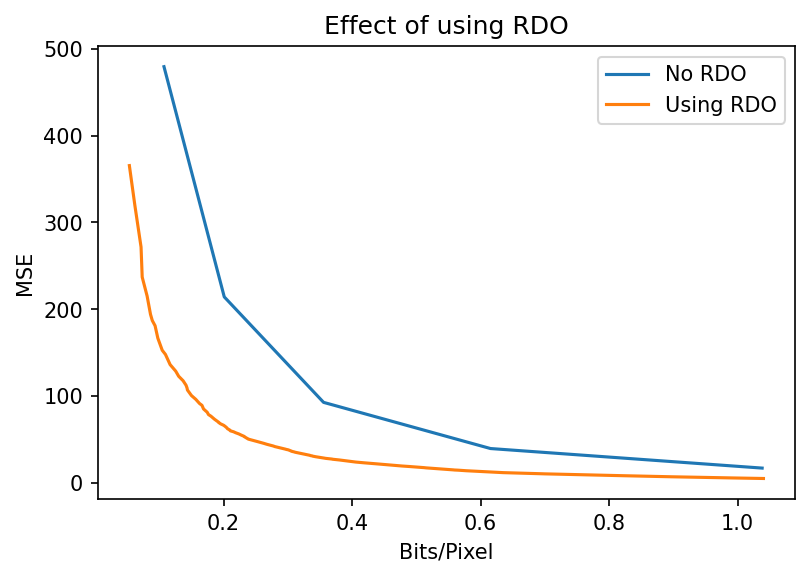

In [12]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_no_RDO), label="No RDO")
pylab.plot(*zip(*optimal_RD_points), label="Using RDO")
pylab.title("Effect of using RDO")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
#pylab.yscale('log')
#pylab.xscale('log')
pylab.show()

## Let's see the effect of redistributing the subbands

In [99]:
def redistribute_subbands(G, blocks_in_y, blocks_in_x):
    for by in range(blocks_in_y*blocks_in_x):
        for bx in range(G):
            subband_index = by*G + bx
            #print(subband_index, end=' ')
            frame_index = subband_index % G
            #print(frame_index, end=' ')
            column_index = subband_index & frame_index
            print(column_index, end=' ')
def redistribute_subbands(G, blocks_in_y, blocks_in_x):
    for by in range(blocks_in_y*blocks_in_x):
        for bx in range(G):
            print(bx, by*blocks_in_x % (blocks_in_x*blocks_in_y) )
def redistribute_subbands(G, blocks_in_y, blocks_in_x):
    for f in range(G):
        for bx in range(blocks_in_x):
            for by in range(blocks_in_y):
                print(f, bx, by, end=' ')
                print((by*blocks_in_x+bx)*blocks_in_x, end=' ')
                print(((by*blocks_in_x+bx)*blocks_in_x % 12), end=' ')
                print(((by*blocks_in_x+bx)*blocks_in_x % 12) + bx, end=' ')
                #print(bx % G, end=' ')
                print()
def redistribute_subbands(G, blocks_in_y, blocks_in_x):
    for f in range(G):
        for by in range(blocks_in_y):
            for bx in range(blocks_in_x):
                print(f"({f},{by},{bx}) -> ({(by*blocks_in_x + bx) % G},{(by*blocks_in_x+bx)*(blocks_in_x)})")
redistribute_subbands(G=2, blocks_in_y=4, blocks_in_x=3)

(0,0,0) -> (0,0)
(0,0,1) -> (1,3)
(0,0,2) -> (0,6)
(0,1,0) -> (1,9)
(0,1,1) -> (0,12)
(0,1,2) -> (1,15)
(0,2,0) -> (0,18)
(0,2,1) -> (1,21)
(0,2,2) -> (0,24)
(0,3,0) -> (1,27)
(0,3,1) -> (0,30)
(0,3,2) -> (1,33)
(1,0,0) -> (0,0)
(1,0,1) -> (1,3)
(1,0,2) -> (0,6)
(1,1,0) -> (1,9)
(1,1,1) -> (0,12)
(1,1,2) -> (1,15)
(1,2,0) -> (0,18)
(1,2,1) -> (1,21)
(1,2,2) -> (0,24)
(1,3,0) -> (1,27)
(1,3,1) -> (0,30)
(1,3,2) -> (1,33)


In [ ]:
optimal_RD_points_with_redistribution = []
yy_prog = np.zeros_like(yy)
Q_steps_combination = np.full(shape=(block_x_side, block_y_side, N_components), fill_value=99999999)
for s in sorted_slopes:
    sbc_index = s[1]
    _y = sbc_index[0]
    _x = sbc_index[1]
    _c = sbc_index[2]
    Q_steps_combination[_y, _x, _c] = s[2]
    yy_prog[blocks_in_y*_y : blocks_in_y*(_y + 1),
            blocks_in_x*_x : blocks_in_x*(_x + 1),
            _c] = yy[blocks_in_y*_y : blocks_in_y*(_y + 1),
                     blocks_in_x*_x : blocks_in_x*(_x + 1),
                     _c]
    yy_prog_k = DCT.quantize(yy_prog, Q_steps_combination)
    yy_prog_dQ = DCT.dequantize(yy_prog_k, Q_steps_combination)
    
    MSE = distortion.MSE(yy, yy_prog_dQ)
    # Before compressing, redistribute the subbands
    BPP = image.write((yy_prog_k + 128).astype(np.uint8), f"/tmp/{_y}_{_x}_{_c}_{s[0]}_", 0)*8/xx.size
    point = (BPP, MSE)
    print("sbc =", sbc_index, "Q_step =", s[2], "BPP =", BPP, "MSE =", MSE)
    optimal_RD_points_with_redistribution.append(point)

## Conclusions
The use of RD optimization increases the performance of the (color_transform + spatial_transform + entropy coding)-procedure, and more concretely of YCoCg + NxN-DCT + PNG. This is a consequence of selecting those quantization steps for the subband-components that contribute more to the quality of the reconstruction.